In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
import nilearn as nil
from nilearn import *
from pydicom import dcmread
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Extracting and processing image data

- Form 3D matrix structure
- List of images

In [2]:
# Getting MRI images for Parkinson's subjects

MRIPathPD = './MRI/PPMI_PD'

MRIsPD = []  # Container for all MRI images

# Walk down the file tree to obtain all dicom files

for root, dirs, files in os.walk(MRIPathPD):
    
    for file in files:  # Only convert the files
        
        # Read and extract pixel data from each dicom image
        # Resize all images to 64 x 64 size
        # Normalize pixel values to be between 0 and 1 (max uint16 value is 65535)
        # Add each pixel array to the image container
        
        rawScan = nil.image.load_img(os.path.join(root, file))
        
        niftiFile = nil.image.get_data(rawScan)

        for i in range(len(niftiFile)):
            
            # Only selecting the slices that contain the Subthalamic Nucleus
            # For sagittal slices:
            # 17 mm lateral to the midline to 3 mm lateral to the midline on both sides for both STNs
            
            midSlice = len(niftiFile) // 2
            
            leftLowerBound = midSlice - 17
            leftUpperBound = midSlice - 3
            rightLowerBound = midSlice + 3
            rightUpperBound = midSlice + 17
            
            if ((i >= leftLowerBound) and (i <= leftUpperBound)) or ((i >= rightLowerBound) and (i <= rightUpperBound)):
            
                meanVal = np.mean(niftiFile[i])
                stdVal = np.std(niftiFile[i])
        
                normNifti = (niftiFile[i] - meanVal) / (stdVal)

                MRIsPD.append(normNifti)
    
# Creating labels based on total number of Parkinson's subjects

PDLabels = np.ones(len(MRIsPD))

In [3]:
# Getting MRI images for healthy subjects

MRIPathHealth = './MRI/PPMI_Healthy'

MRIsHealth = []  # Container for all MRI images

# Walk down the file tree to obtain all dicom files

for root, dirs, files in os.walk(MRIPathHealth):
    
    for file in files:  # Only convert the files
        
        # Read and extract pixel data from each dicom image
        # Resize all images to 64 x 64 size
        # Normalize pixel values to be between 0 and 1 (max uint16 value is 65535)
        # Add each pixel array to the image container
        
        rawScan = nil.image.load_img(os.path.join(root, file))

        niftiFile = nil.image.get_data(rawScan)
        
        for i in range(len(niftiFile)):
            
            # Only selecting the slices that contain the Subthalamic Nucleus
            # For sagittal slices:
            # 17 mm lateral to the midline to 3 mm lateral to the midline on both sides for both STNs
            
            midSlice = len(niftiFile) // 2
            
            leftLowerBound = midSlice - 17
            leftUpperBound = midSlice - 3
            rightLowerBound = midSlice + 3
            rightUpperBound = midSlice + 17
            
            if ((i >= leftLowerBound) and (i <= leftUpperBound)) or ((i >= rightLowerBound) and (i <= rightUpperBound)):
            
                meanVal = np.mean(niftiFile[i])
                stdVal = np.std(niftiFile[i])
        
                normNifti = (niftiFile[i] - meanVal) / (stdVal)

                MRIsHealth.append(normNifti)
    
# Creating labels based on total number of healthy subjects

healthLabels = np.zeros(len(MRIsHealth))

# Forming Model Input

In [4]:
# Combining image data and labels
# Converting lists to numpy arrays

MRIsPD = np.array(MRIsPD, dtype=object)
MRIsHealth = np.array(MRIsHealth, dtype=object)

MRIs = np.vstack((MRIsPD, MRIsHealth))

labels = np.append(PDLabels, healthLabels)

In [5]:
# Splitting data into training and testing sets

MRIsTrain, MRIsTest, labelsTrain, labelsTest = train_test_split(MRIs, labels, test_size=0.30, random_state=0, shuffle=True)

# Converting outer lists to numpy arrays for model compatibility
# 32-bit float type necessary for model

MRIsTrain = np.asarray(MRIsTrain).astype('float32')
labelsTrain = np.asarray(labelsTrain)
MRIsTest = np.asarray(MRIsTest).astype('float32')
labelsTest = np.asarray(labelsTest)

# Building Convolutional Neural Network

In [6]:
# Building convolutional neural network model

CNN = models.Sequential()

# Most common form of convolutional network
# Alternating Conv2D and MaxPooling2D layers
# Input shape to first layer is (Image Height, Image Width, # of Color Channels)

CNN.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 1)))  # Grayscale slices = 1 color channel
CNN.add(layers.MaxPooling2D(pool_size = (2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D(pool_size = (2, 2)))
CNN.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Classification layer necessary after convolution

CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(2, activation='relu'))  # 2 classes: Healthy (0), Parkinsons (1)

# Training and Testing Model

In [7]:
# Training model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

CNN.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

training = CNN.fit(MRIsTrain, labelsTrain, epochs=3, shuffle=True, callbacks=[callback])

Epoch 1/3
31/31 [==============================] - 152s 5s/step - loss: 0.7175 - accuracy: 0.5072
Epoch 2/3
31/31 [==============================] - 132s 4s/step - loss: 0.5515 - accuracy: 0.7578
Epoch 3/3
31/31 [==============================] - 130s 4s/step - loss: 0.4861 - accuracy: 0.9141


In [8]:
# Testing model

loss, accuracy = CNN.evaluate(MRIsTest, labelsTest, verbose = 2)
predictionProbs = CNN.predict(MRIsTest, verbose = 2)    # For specificity and sensitivity calculations

13/13 - 15s - loss: 0.3624 - accuracy: 0.9831 - 15s/epoch - 1s/step
13/13 - 13s - 13s/epoch - 1s/step


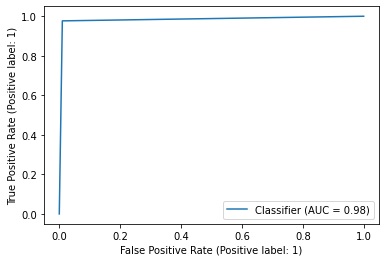

In [9]:
# Calculating extra metrics

predictionLabels = predictionProbs.argmax(axis = -1)    # Get prediction classes from probabilities

tn, fp, fn, tp = confusion_matrix(labelsTest, predictionLabels).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

rocCurve = RocCurveDisplay.from_predictions(labelsTest, predictionLabels)

# Reviewing Model Performance

In [10]:
# Report metrics

print("Model Test Accuracy:", accuracy)
print("Model Test Sensitivity:", sensitivity)
print("Model Test Specificity:", specificity)

Model Test Accuracy: 0.9830917716026306
Model Test Sensitivity: 0.9766355140186916
Model Test Specificity: 0.99
